In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# preprocessed data importation
df = pd.read_csv("../data/df_preprocessed.csv", parse_dates=['date_heure'], index_col='date_heure')
df.head()


,conso_elec_MW,hour,dayofweek,month,is_weekend,is_working_hour
date_heure,,,,,,
2012-01-01 00:00:00,59610,0,6,1,1,0
2012-01-01 00:30:00,58314,0,6,1,1,0
2012-01-01 01:00:00,56230,1,6,1,1,0
2012-01-01 01:30:00,56075,1,6,1,1,0
2012-01-01 02:00:00,55531,2,6,1,1,0


In [ ]:
# Forecast the demand for the next 24h = 48 shifts (1 row = 30min)
df['target_t_plus_48'] = df['conso_elec_MW'].shift(-48)

# Drop the rows where target is NaN at the end of the dataset (because of the shifts)
df = df.dropna(subset=['target_t_plus_48'])


In [ ]:
# Lags creation
lags = [1, 2, 3, 6, 12, 24, 48, 96]  # En pas de 30 min

for lag in lags:
    df[f'lag_{lag}'] = df['conso_elec_MW'].shift(lag)

# On retire les lignes qui contiennent des NaN à cause des lags
df = df.dropna()


In [37]:
X = df[[f'lag_{lag}' for lag in lags] + ['hour', 'dayofweek', 'month', 'is_weekend']]
y = df['target_t_plus_48']



In [ ]:
#train/test split without time consideration

from sklearn.model_selection import train_test_split

split_idx = int(len(df_features) * 0.8)  # 80% pour l'entraînement

X_train = df_features.iloc[:split_idx]
y_train = target.iloc[:split_idx]

X_test = df_features.iloc[split_idx:]
y_test = target.iloc[split_idx:]



print("Train :", X_train.shape)
print("Test :", X_test.shape)


Train : (186816, 12)
Test : (46704, 12)


In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Coefficients :", model.coef_)
print("Intercept :", model.intercept_)


Coefficients : [ 1.67570773e+00 -6.36478461e-01 -1.02908919e-01  3.03606093e-02
  3.99383969e-04  2.71267917e-02 -3.08969056e-01  2.71051859e-01
  2.76461073e+01 -9.44608023e+02 -1.38276973e+01  5.00042950e+03]
Intercept : 3523.7944341914626


In [40]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f" RMSE : {rmse:.2f}")
print(f" R² : {r2:.3f}")


 RMSE : 3400.67
 R² : 0.896


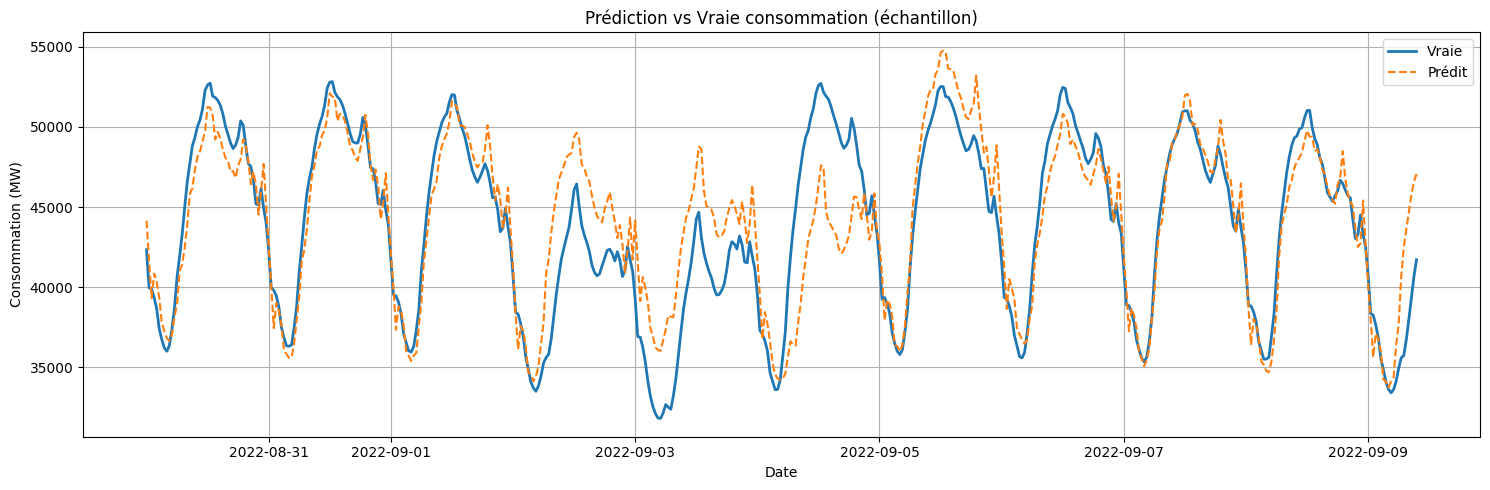

In [41]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index[:500], y_test[:500], label="Vraie", linewidth=2)
plt.plot(y_test.index[:500], y_pred[:500], label="Prédit", linestyle='--')
plt.title("Prédiction vs Vraie consommation (échantillon)")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


[Random Forest] RMSE : 2248.06
[Random Forest] R² : 0.954


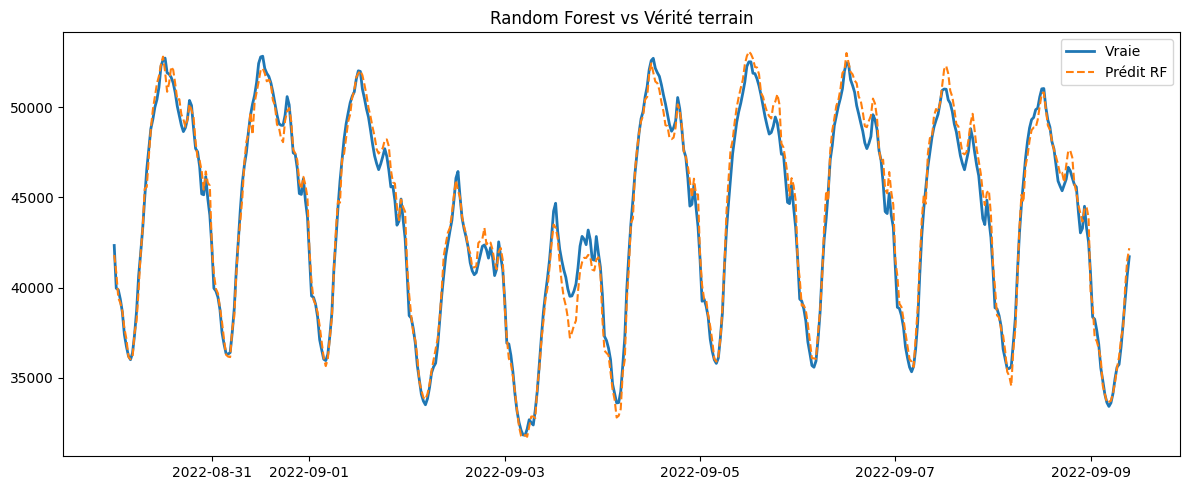

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Définir et entraîner le modèle
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 2. Prédictions
y_pred_rf = rf.predict(X_test)

# 3. Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"[Random Forest] RMSE : {rmse_rf:.2f}")
print(f"[Random Forest] R² : {r2_rf:.3f}")

# 4. Visualisation
plt.figure(figsize=(12, 5))
plt.plot(y_test.index[:500], y_test[:500], label="Vraie", linewidth=2)
plt.plot(y_test.index[:500], y_pred_rf[:500], label="Prédit RF", linestyle='--')
plt.legend()
plt.title("Random Forest vs Vérité terrain")
plt.tight_layout()
plt.show()


In [47]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Définir le modèle
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# 2. Entraînement
xgb_model.fit(X_train, y_train)

# 3. Prédiction
y_pred = xgb_model.predict(X_test)

# 4. Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE : {rmse:.2f}")
print(f" R² : {r2:.3f}")


 RMSE : 2305.08
 R² : 0.952


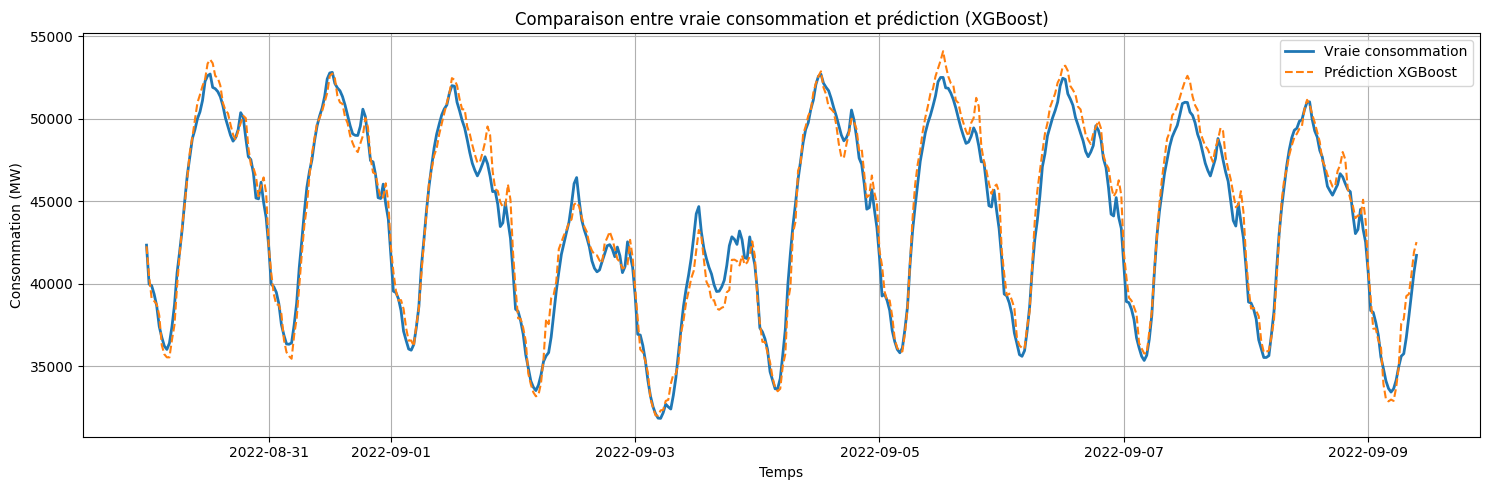

In [45]:
# Prédictions du modèle XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Tracer sur les 500 premiers points pour la lisibilité
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[:500], y_test[:500], label="Vraie consommation", linewidth=2)
plt.plot(y_test.index[:500], y_pred_xgb[:500], label="Prédiction XGBoost", linestyle="--")
plt.title("Comparaison entre vraie consommation et prédiction (XGBoost)")
plt.xlabel("Temps")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()